# RapidWright Tutorial - Build a Basic Router
In this Jupyter notebook tutorial, you'll learn: 
 1. The basic types and resources available for routing in RapidWright
 2. How to build a bare bones router

## Background 
This Jupyter Notebook provides a brief primer on the basics of routing in RapidWright.  
### Basics of Routing
Routing--mapping a net to interconnect resources on the FPGA--has two parts: inter-site routing and intra-site routing.  

Inter-site routing uses the global interconnect to connect sites to sites.  This is the same kind of routing performed by Vivado's `route_design` Tcl command.  Intra-site routing is routing internal to a site, assigning site wires to nets and generally takes place during placement (Vivado's `place_design`).  This tutorial will focus on inter-site routing and avoids the details of special cases such as clock and gnd/vcc routing.  

#### What is a Net?
In RapidWright, we have two kinds of nets, logical and physical.  A logical net is a network of connected cell pins (both hierarchical and leaf) of a netlist.  A physical net describes connections between physical site pins and crosses hierarchical boundaries of the netlist.  Consider these two types of nets in the table below:

|Net Type    |RapidWright Class|Crosses Hierarchy?|Pins Live on a...    |
|------------|-----------------|------------------|---------------------|
|Logical Net |`EDIFNet`        |No                |Cell (`EDIFCellInst`)|
|Physical Net|`Net`            |Yes               |Site (`SiteInst`)    |

To illustrate the difference between these two kinds of nets, consider the Vivado screenshot below of a single physical net that maps to three logical nets:

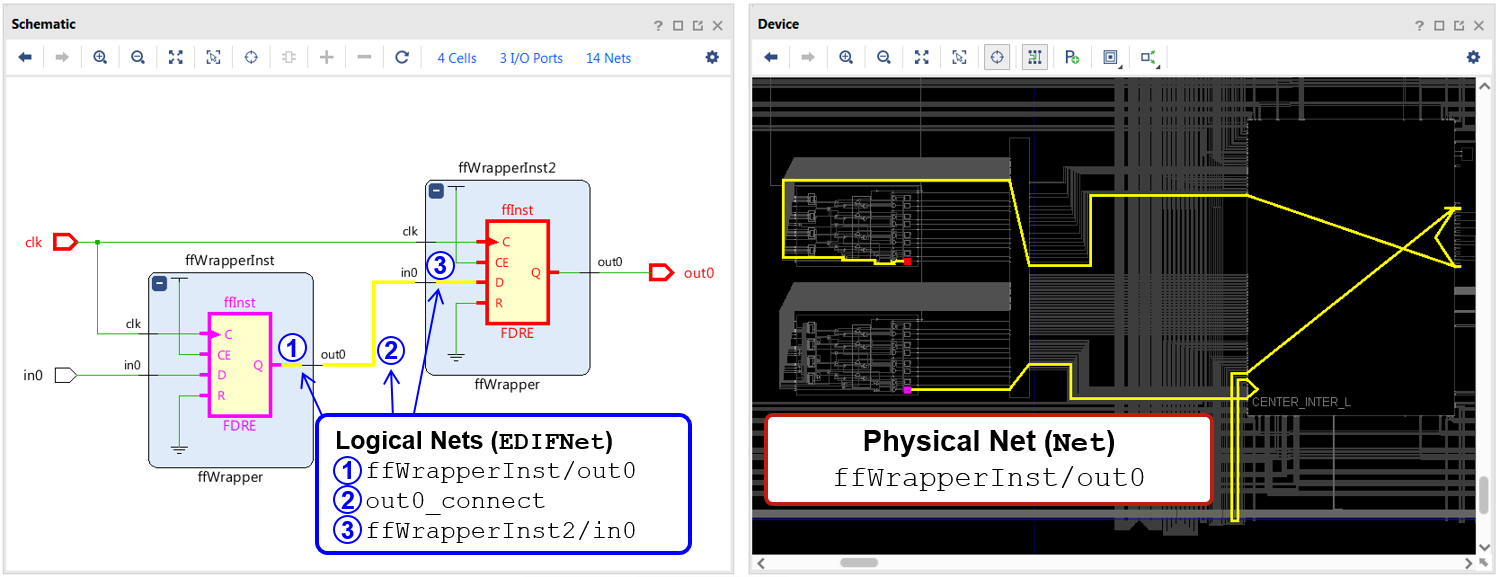

Note that the physical net takes the name of the source logical net (the net connected to the source leaf cell), this is the typical convention used in Vivado and RapidWright.  A physical RapidWright `Net` has a few notable components:

|Class Member|Description      |API Getter        |  
|------------|-----------------|------------------|
|name        |Full hierarchical name of the net| `public String Net.getName()`|
|pins        |Source/Sink site pins| `public List<SitePinInst> Net.getPins()`|
|pips        |Programmable interconnect Points used| `public List<PIP> Net.getPIPs()`|

The ultimate goal of routing is to select a set of PIPs for each net that physically connects the source pin to each sink pin.  In order to to understand how to select PIPs, let's take a look at the routing resources available.

### Routing Resources
Below is an illustration of specific examples of each type of routing resource:
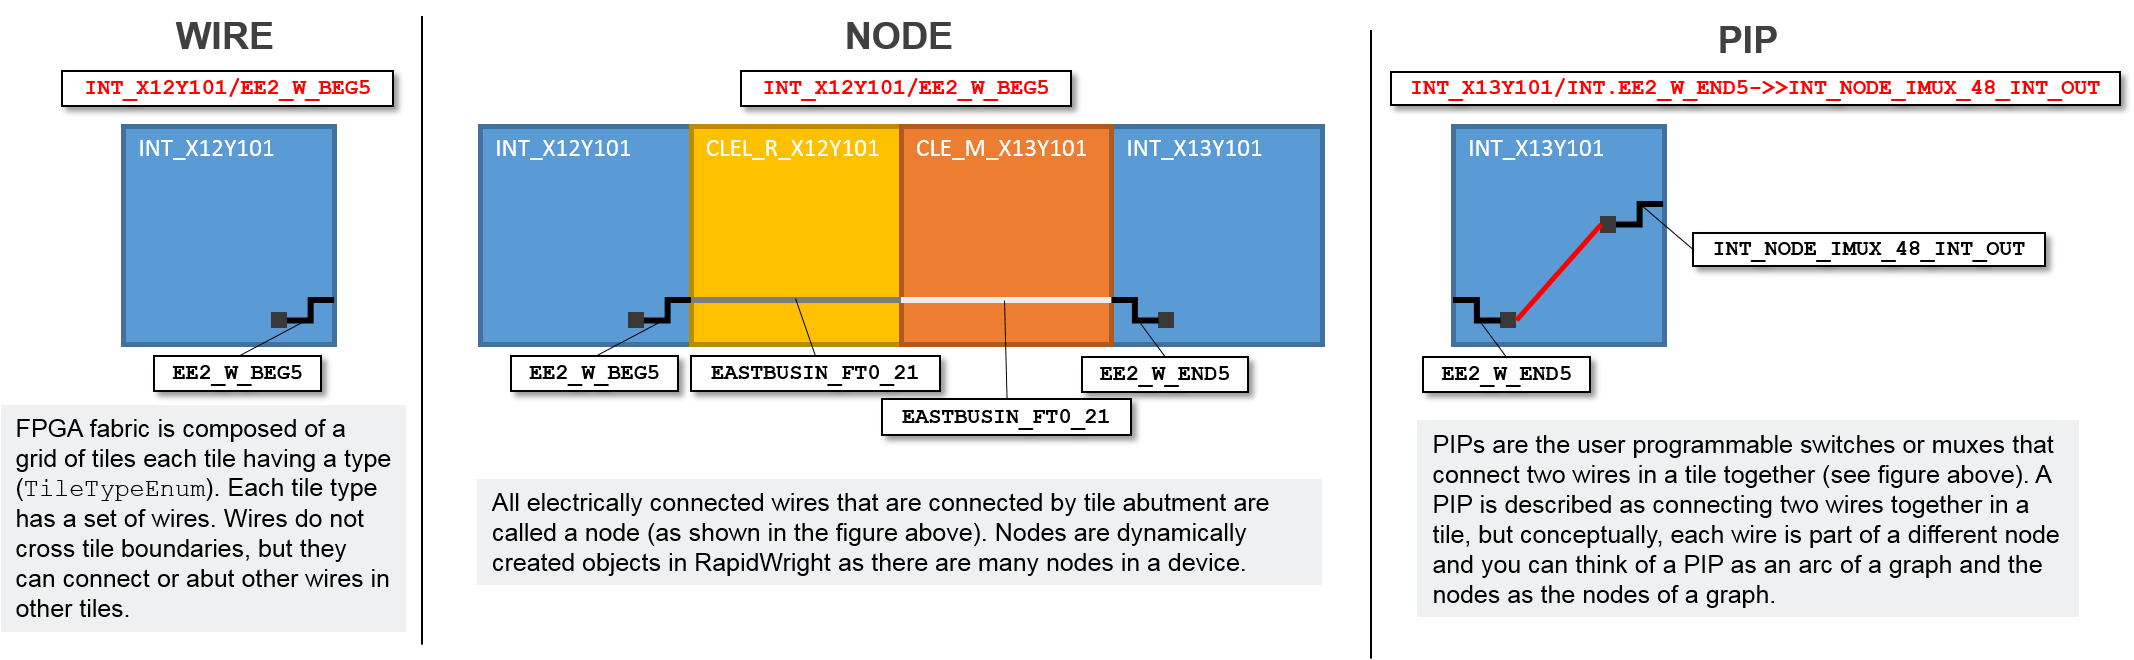
The textbox in red shows the name used to identify the specific routing resource in both Vivado and RapidWright.  

## Let's Get Routing!
To get started we need a routing problem, so let's setup a simple example to route between two flip flops:

In [1]:
# Import RapidWright classes

from com.xilinx.rapidwright.design import Cell
from com.xilinx.rapidwright.design import Design
from com.xilinx.rapidwright.design import DesignTools
from com.xilinx.rapidwright.design import Net
from com.xilinx.rapidwright.design import NetType
from com.xilinx.rapidwright.design import PinType
from com.xilinx.rapidwright.design import Unisim
from com.xilinx.rapidwright.device import Device
from com.xilinx.rapidwright.device import Node
from com.xilinx.rapidwright.edif   import EDIFDirection
from com.xilinx.rapidwright.edif   import EDIFTools
from com.xilinx.rapidwright.router import RouteNode
from com.xilinx.rapidwright.router import Router
from com.xilinx.rapidwright.util   import MessageGenerator
from java.util import HashSet
from java.util import List
from pprint import pprint

def createTopPortNet(name, direction):
    net = top.createNet(name)
    port = top.createPort(name,direction, 1)
    net.createPortInst(port)
    return net

def makeFlipFlop(name, loc):
    ff = design.createAndPlaceCell(name, Unisim.FDRE, loc)
    gnd.createPortInst("R" , ff.getEDIFCellInst())
    vcc.createPortInst("CE", ff.getEDIFCellInst())
    clk.createPortInst("C" , ff.getEDIFCellInst())
    return ff

# Create a new, empty design
design = Design("MyFirstRoute",Device.PYNQ_Z1)
# Get some useful handles
device = design.getDevice()
netlist = design.getNetlist()
top = netlist.getTopCell()
gnd = EDIFTools.getStaticNet(NetType.GND, top, netlist);
vcc = EDIFTools.getStaticNet(NetType.VCC, top, netlist);
ports = {"clk":EDIFDirection.INPUT, "in0":EDIFDirection.INPUT,"out0":EDIFDirection.OUTPUT}
(clk, in0, out0) = tuple([createTopPortNet(k,v) for k,v in ports.iteritems()])

# Create our source and sink flip flops, connect plumbing pins (clk, ce, rst)
src_ff = makeFlipFlop("src_ff", "SLICE_X0Y4/AFF")
snk_ff = makeFlipFlop("snk_ff", "SLICE_X2Y4/BFF")

# Create the net to route and connect it to the FFs
net = design.createNet("ff_net")
src = DesignTools.createPinAndAddToNet(src_ff,"Q",net)
snk = DesignTools.createPinAndAddToNet(snk_ff,"D",net)
in0.createPortInst("D",src_ff.getEDIFCellInst())
out0.createPortInst("Q",snk_ff.getEDIFCellInst())

# These make the design route-able by Vivado (sanity check)
design.routeSites()
design.setAutoIOBuffers(False)
design.setDesignOutOfContext(True)
design.writeCheckpoint(design.getName() + ".dcp")
print "Wrote: " + design.getName() + ".dcp"

Wrote: MyFirstRoute.dcp


If we open up `MyFirstRoute.dcp` in Vivado and look at the device view, we can see our two-flip-flop-design with an unrouted net connecting shown in red:
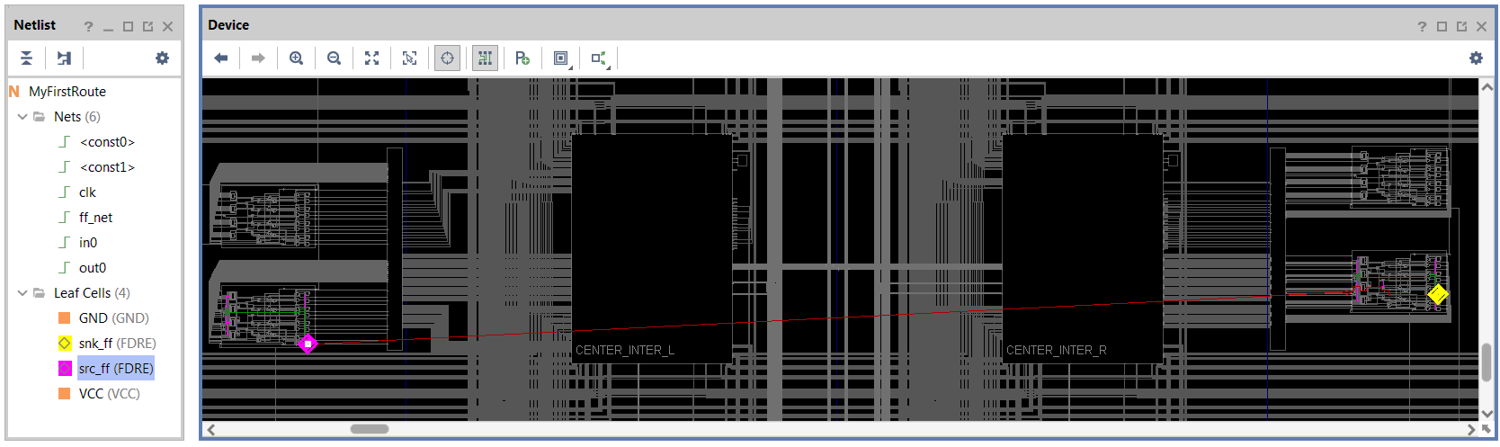

Now that the stage is set, we can focus on writing some code to connect these two flip flops together.

In [2]:
# Let's put our route routine into a function
def findRoute(src, snk):
    # We will use a priority queue to sort through the nodes we encounter, 
    # those with the least cost will fall to the bottom
    q = RouteNode.getPriorityQueue()
    q.add(src)
    
    # We'll keep track of where we have visited and a watchdog timer
    visited = HashSet()
    watchdog = 50000
    
    # While we still have nodes to look at, keep expanding
    while(not q.isEmpty()):
        curr = q.poll()
        if(curr.equals(snk)):
            print "Visited Wire Count: " + str(visited.size())
            # We've found the sink, recover our trail of used PIPs 
            return curr.getPIPsBackToSource()
        
        visited.add(curr)
        watchdog = watchdog - 1
        if(watchdog < 0): break
        # Print our search path to help debugging easier
        # print MessageGenerator.makeWhiteSpace(curr.getLevel()) + str(curr)
        # Expand the current node to look for more nodes/paths
        for wire in curr.getConnections():
            nextNode = RouteNode(wire,curr)
            if wire.isRouteThru(): continue
            if visited.contains(nextNode): continue
            # Let's use a simple Manhattan distance for our cost function
            nextNode.setCost(nextNode.getManhattanDistance(snk))
            q.add(nextNode)
    # Unroutable situation
    print "Route failed!"
    return

net.setPIPs(findRoute(src.getRouteNode(), snk.getRouteNode()))
print "PIP Count: "+str(net.getPIPs().size())
#for p in net.getPIPs():
#    print p

design.writeCheckpoint(design.getName() +".dcp")

Visited Wire Count: 250
PIP Count: 13


We see that we are able to find a path using 13 PIPs, however, from our view of the path in Vivado, we see that it is  not optimal:
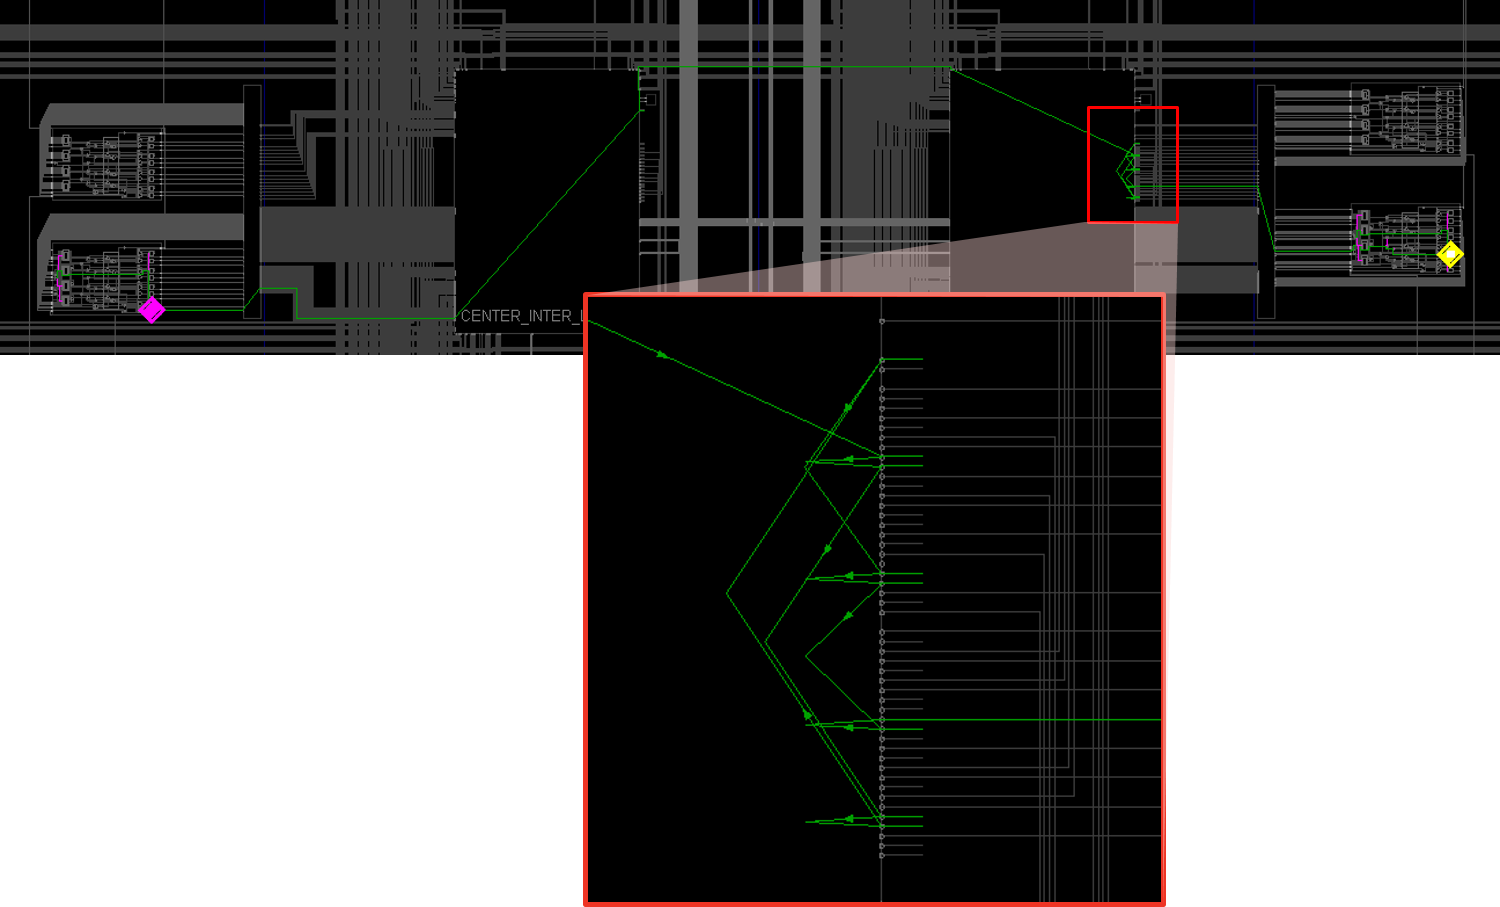

Our route routine found the sink alright, but it bounces around in the switch box several times before reaching the destination.  This is a symptom of the cost function we chose in the code above, we used a strict Manhattan distance cost. Lets modify the cost function such that it also takes into account the number of hops we have taken from the source.  In `RouteNode` this parameter is stored as the `level` or number of levels away from the source it is.  A copy of the code above with a revised cost function is provided below:

In [3]:
# Let's put our route routine into a function
def findRoute(src, snk):
    # We will use a priority queue to sort through the nodes we encounter, 
    # those with the least cost will fall to the bottom
    q = RouteNode.getPriorityQueue()
    q.add(src)
    
    # We'll keep track of where we have visited and a watchdog timer
    visited = HashSet()
    watchdog = 50000
    
    # While we still have nodes to look at, keep expanding
    while(not q.isEmpty()):
        curr = q.poll()
        if(curr.equals(snk)):
            print "Visited Wire Count: " + str(visited.size())
            # We've found the sink, recover our trail of PIPs 
            return curr.getPIPsBackToSource()
        
        visited.add(curr)
        watchdog = watchdog - 1
        if(watchdog < 0): break
        # Print our search path to help debugging easier
        # print MessageGenerator.makeWhiteSpace(curr.getLevel()) + str(curr)
        # Expand the current node to look for more nodes/paths
        for wire in curr.getConnections():
            nextNode = RouteNode(wire,curr)
            if wire.isRouteThru(): continue
            if visited.contains(nextNode): continue
            # Now we've modified our cost function to include levels or hops from source
            # along with Manhattan distance
            nextNode.setCost(nextNode.getManhattanDistance(snk) + nextNode.getLevel())
            q.add(nextNode)
    # Unroutable situation
    print "Route failed!"
    return

net.setPIPs(findRoute(src.getRouteNode(), snk.getRouteNode()))
print "PIP Count: "+str(net.getPIPs().size())
#for p in net.getPIPs():
#    print p

design.writeCheckpoint(design.getName() +".dcp")

Visited Wire Count: 1582
PIP Count: 5


With updated cost function, we get a route that only requires five PIPs, much better:
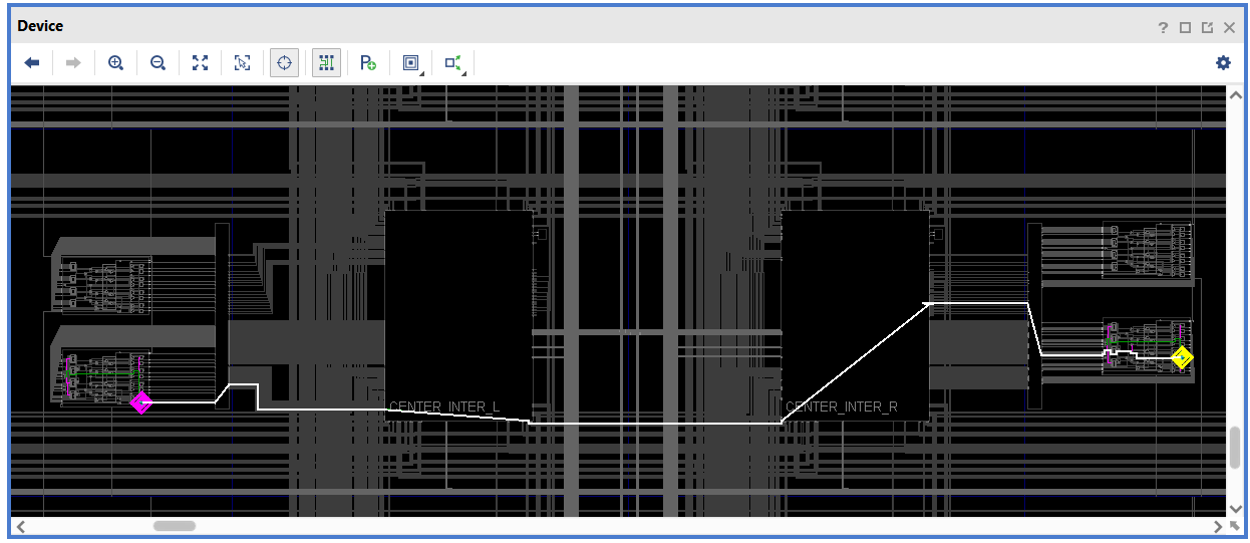
But notice that the number of visited wires went up by 6X!  Maybe we can tweek the cost function further by multiplying a co-efficient to the number of levels back to the source. Here are a few exercises you can try to minimize the visited wired count:
1. Multiply/divide a co-efficient on `nextNode.getLevel()` (line 31) to experiment towards a better cost function
2. Try filtering out nodes before putting them into the queue on line 32.  If we know a node won't lead to the sink, we don't need to further expand it. 
> ***HINT:***
> You can print out the visited nodes during a run by uncommenting line 24.

## Routing to Multiple Sinks
If we were to add an additional sink to our design, we could enlarge the routing problem to include multiple sinks.  

In [4]:
# Create another sink flip-flop and connect it to the net
snk2_ff = makeFlipFlop("snk2_ff", "SLICE_X2Y5/BFF")
snk2 = DesignTools.createPinAndAddToNet(snk2_ff,"D",net)
out1 = createTopPortNet("out1",EDIFDirection.OUTPUT)
out1.createPortInst("Q",snk2_ff.getEDIFCellInst())

# We've got to update some internal netlist data structures
# after changing the netlist
design.getNetlist().resetParentNetMap()
design.routeSites()

Now we have one additional sink we need to route to in order to completely satisfy the routing.  With multiple sinks, it would be advantageous to keep around some of the intermediate path found in the first route and use it as a starting point for the second.  We can do this in a couple of different ways.  One way is to add another function called `routeNet()` that calls `findRoute()` multiple times and replaces the `src` parameter with a priority queue that is managed by the `routeNet()`.  

In [15]:
def routeNet(net):
    # We will use a priority queue to sort through the nodes we encounter, 
    # those with the least cost will fall to the bottom
    q = RouteNode.getPriorityQueue()
    q.add(net.getSource().getRouteNode())

    # Keep track of all PIPs used
    allUsedPIPs = HashSet()
    
    # For each sink, run findRoute() 
    for sink in net.getPins():
        if sink.equals(net.getSource()): 
            continue
        # If we already have some PIPs dedicated to the route, let's 
        # add them to the queue to be used for future routes
        if allUsedPIPs.size() > 0:
            q.clear()
            for pip in allUsedPIPs:
                q.add(RouteNode(pip.getTile(),pip.getStartWireIndex()))
                q.add(RouteNode(pip.getTile(),pip.getEndWireIndex()))
        path = findRoute(q,sink.getRouteNode())
        if path == None:
            print "Failed to route: " + net.getName() + " ("+sink.getSite().getName()+"/"+sink.getName()+")"
        else:
            allUsedPIPs.addAll(path)

    # Attach our final set of PIPs to the route
    net.setPIPs(allUsedPIPs)
        
# Let's put our route routine into a function
def findRoute(q, snk):
    # We'll keep track of where we have visited and a watchdog timer
    visited = HashSet()
    watchdog = 50000
    
    # While we still have nodes to look at, keep expanding
    while(not q.isEmpty()):
        curr = q.poll()
        if(curr.equals(snk)):
            print "Visited Wire Count: " + str(visited.size())
            # We've found the sink, recover our trail of PIPs 
            return curr.getPIPsBackToSource()
        
        visited.add(curr)
        watchdog = watchdog - 1
        if(watchdog < 0): break
        # Print our search path to help debugging easier
        # print MessageGenerator.makeWhiteSpace(curr.getLevel()) + str(curr)
        # Expand the current node to look for more nodes/paths
        for wire in curr.getConnections():
            nextNode = RouteNode(wire,curr)
            if wire.isRouteThru(): continue
            if visited.contains(nextNode): continue
            # Now we've modified our cost function to include levels or hops from source
            # along with Manhattan distance
            nextNode.setCost(nextNode.getManhattanDistance(snk) + nextNode.getLevel() / 4)
            q.add(nextNode)
    # Unroutable situation
    print "Route failed!"
    return

# Let's route!
routeNet(net)
print "PIP Count: "+str(net.getPIPs().size())
#for p in net.getPIPs():
#    print p

design.writeCheckpoint(design.getName() +".dcp")

Visited Wire Count: 867
Visited Wire Count: 130
PIP Count: 9


Note that the expansion search visits only ~15% of the route nodes visited in the original path by allowing the router to reuse the PIPs already allocated in the first route.  Our net should now look like this:
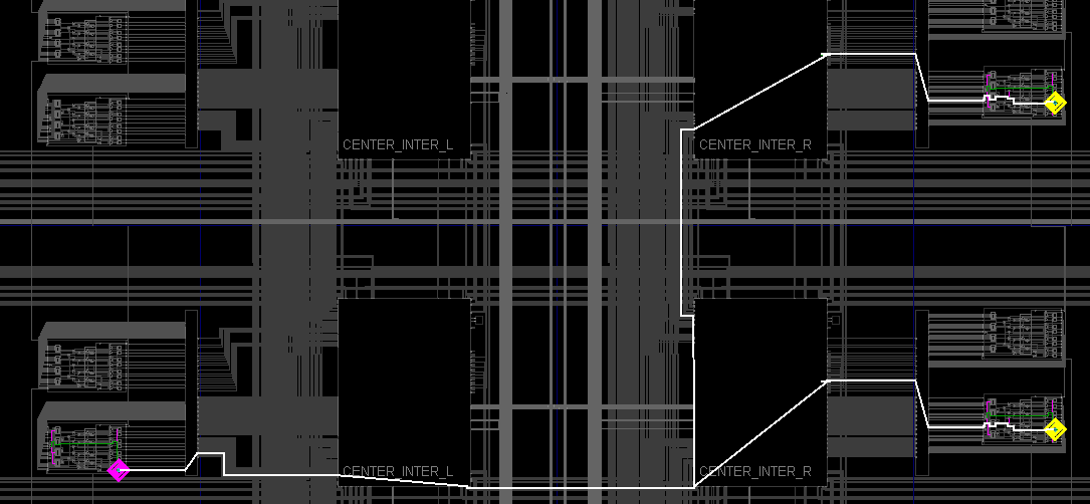
This is a great next step, but it would be a lot more useful to route many nets at a time.  Let's try routing a design:

In [16]:
design = Design.readCheckpoint('reduction_or_routed.dcp')
design.unrouteDesign()

for n in design.getNets():
    if n.isStaticNet() or n.isClockNet(): continue
    if n.getSource() == None: continue
    routeNet(n)

design.writeCheckpoint('reduction_or_basic_routed.dcp')
print "Wrote reduction_or_basic_routed.dcp"

Visited Wire Count: 299
Visited Wire Count: 152
Visited Wire Count: 89
Visited Wire Count: 86
Visited Wire Count: 728
Visited Wire Count: 44
Visited Wire Count: 269
Visited Wire Count: 168
Visited Wire Count: 42
Visited Wire Count: 950
Visited Wire Count: 176
Visited Wire Count: 267
Visited Wire Count: 159
Visited Wire Count: 75
Visited Wire Count: 270
Visited Wire Count: 137
Visited Wire Count: 333
Visited Wire Count: 430
Visited Wire Count: 949
Visited Wire Count: 2217
Visited Wire Count: 308
Visited Wire Count: 1418
Visited Wire Count: 76
Visited Wire Count: 90
Visited Wire Count: 404
Visited Wire Count: 283
Visited Wire Count: 252
Visited Wire Count: 86
Visited Wire Count: 222
Visited Wire Count: 2157
Visited Wire Count: 203
Visited Wire Count: 893
Visited Wire Count: 100
Visited Wire Count: 129
Visited Wire Count: 1900
Visited Wire Count: 122
Visited Wire Count: 819
Visited Wire Count: 308
Visited Wire Count: 221
Visited Wire Count: 110
Visited Wire Count: 130
Visited Wire Count: 

There is a problem with this design, however.  If we open it in Vivado, and run `report_route_status`, we can see various errors:

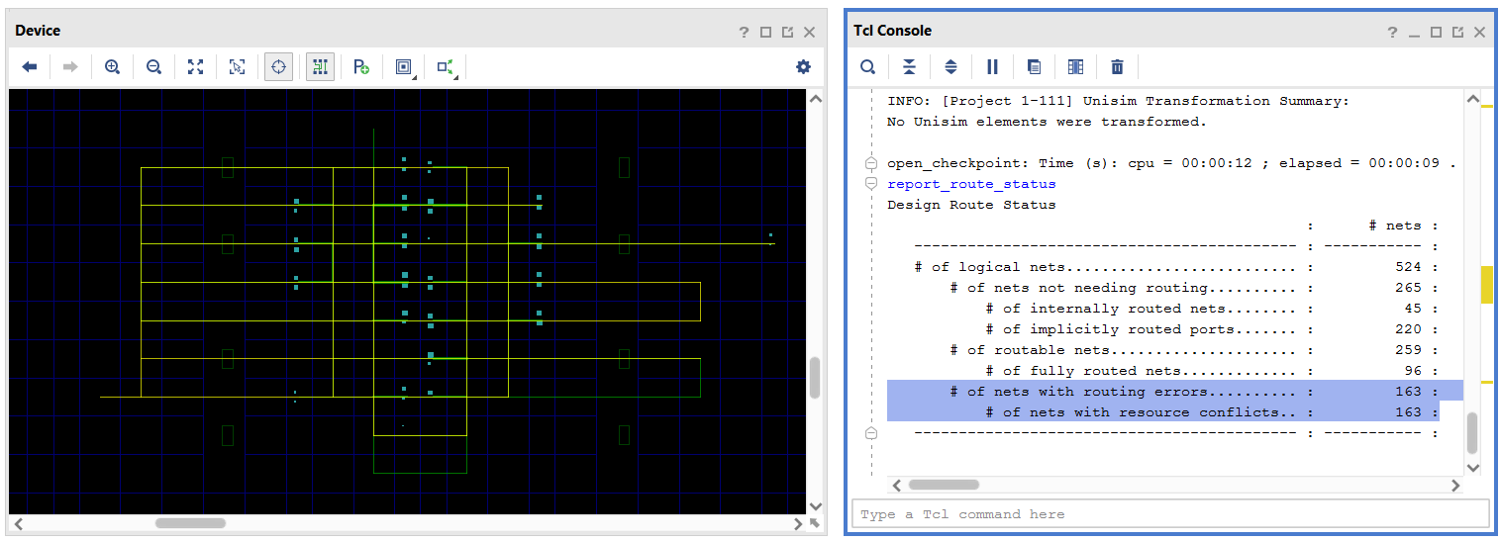

There are 163 routes that are conflicting with one another.  We forgot to address mutual exclusivity of the routing resources and the nets just routed on top of one another.  To resolve this, we can mark `RouteNode`s as used as we route each `Net`.  This is not a congestion resolution approach (something we won't delve into today), but will allow the nodes used in each route to be exclusive to that route.  This design is not dense, so we can get away with out congestion resolution.  

The code below had been modified and we've added a new `usedNodes` `HashSet` to store all the nodes that are occupied after each net is routed.  We have also added a `routeDesign()` function to make the approach a bit cleaner.

In [14]:
def routeDesign(design):
    usedNodes = HashSet()
    for n in design.getNets():
        if n.isStaticNet() or n.isClockNet(): continue
        if n.getSource() == None: continue
        routeNet(n, usedNodes)
    
def routeNet(net, usedNodes):
    # We will use a priority queue to sort through the nodes we encounter, 
    # those with the least cost will fall to the bottom
    q = RouteNode.getPriorityQueue()
    q.add(net.getSource().getRouteNode())

    # Keep track of all PIPs used
    allUsedPIPs = HashSet()
    
    # For each sink, run findRoute() 
    for sink in net.getPins():
        if sink.equals(net.getSource()): 
            continue
        # If we already have some PIPs dedicated to the route, let's 
        # add them to the queue to be used for future routes
        if allUsedPIPs.size() > 0:
            q.clear()
            for pip in allUsedPIPs:
                q.add(RouteNode(pip.getTile(),pip.getStartWireIndex()))
                q.add(RouteNode(pip.getTile(),pip.getEndWireIndex()))
        path = findRoute(q,sink.getRouteNode(), usedNodes)
        if path == None:
            print "Failed to route: " + net.getName() + " ("+sink.getSite().getName()+"/"+sink.getName()+")"
        else:
            allUsedPIPs.addAll(path)

    # Attach our final set of PIPs to the route
    net.setPIPs(allUsedPIPs)
    # Keep track of used nodes for future nets
    for pip in allUsedPIPs:
        usedNodes.add(RouteNode(pip.getTile(),pip.getStartWireIndex()))
        usedNodes.add(RouteNode(pip.getTile(),pip.getEndWireIndex()))
        
# Let's put our route routine into a function
def findRoute(q, snk, usedNodes):
    # We'll keep track of where we have visited and a watchdog timer
    visited = HashSet()
    watchdog = 50000
    
    # While we still have nodes to look at, keep expanding
    while(not q.isEmpty()):
        curr = q.poll()
        if(curr.equals(snk)):
            # print "Visited Wire Count: " + str(visited.size())
            # We've found the sink, recover our trail of PIPs 
            return curr.getPIPsBackToSource()
        
        visited.add(curr)
        watchdog = watchdog - 1
        if(watchdog < 0): break
        # Print our search path to help debugging easier
        # print MessageGenerator.makeWhiteSpace(curr.getLevel()) + str(curr)
        # Expand the current node to look for more nodes/paths
        for wire in curr.getConnections():
            nextNode = RouteNode(wire,curr)
            if wire.isRouteThru(): continue
            if visited.contains(nextNode): continue
            if usedNodes.contains(nextNode): continue
            # Now we've modified our cost function to include levels or hops from source
            # along with Manhattan distance
            nextNode.setCost(nextNode.getManhattanDistance(snk) + nextNode.getLevel() / 4)
            q.add(nextNode)
                
    # Unroutable situation
    return

# Route the design
design = Design.readCheckpoint('reduction_or_routed.dcp')
design.unrouteDesign()

#Router(design).routeDesign() # - Use the RapidWright Router instead
routeDesign(design)

design.writeCheckpoint('reduction_or_basic_routed.dcp')
print "Wrote reduction_or_basic_routed.dcp"

Wrote reduction_or_basic_routed.dcp


This design should successfully route without any issues.  We can confirm this by opening `reduction_or_basic_routed.dcp` in Vivado:
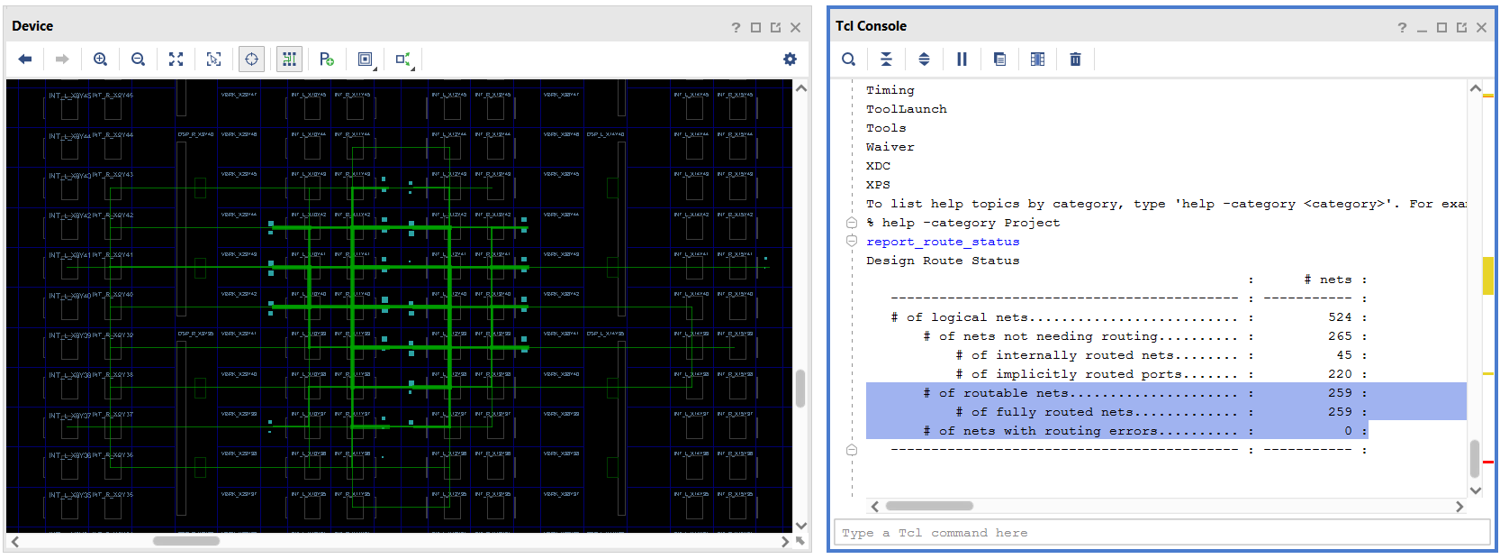
Indeed, the routing is correct, we can verify this by running `report_route_status` and find that 259/259 of routable nets are routed and that there are 0 nets with routing errors.

## Conclude
Routing can be a very difficult and challenging problem.  Research on improving FPGA routing has been a subject studied for decades and there are a lot of details when it comes to getting it all right.  One of the main challenges is solving congestion, which has traditionally been solved using a variation of the [PathFinder algorithm](https://dl.acm.org/citation.cfm?id=201328).  Unfortunately, RapidWright does not have an implementation of PathFinder and leaves the heavy lifting to Vivado or our new exploration feature, SAT-based routing.  Checkout our other [SAT Router tutorial](SATRouter.ipynb) that uses a SAT solver to solve routing congestion on a design that Vivado could not.